# Stethoscope system for heart disease prediction

## Importing the required libraries

In [2]:
import numpy as np
import pandas as pd
import glob
import os
import librosa
import csv
import matplotlib.pyplot as plt

In [3]:
SAMPLE_RATE = 16000
MAX_SOUND_CLIP_DURATION=12

## Reading the csv files

In [4]:
set_a=pd.read_csv('C:\\Users\\dell\\audio-data\\set_A.csv')

In [5]:
set_a

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN
...,...,...,...,...
100,a,set_a/normal__201106221450.wav,normal,NaN
101,a,set_a/normal__201108011112.wav,normal,NaN
102,a,set_a/normal__201108011114.wav,normal,NaN
103,a,set_a/normal__201108011115.wav,normal,NaN


In [6]:
set_b=pd.read_csv('C:\\Users\\dell\\audio-data\\set_B.csv')

In [7]:
set_b

,dataset,fname,label,sublabel
0,b,set_b/Btraining_murmur_112_1306243000964_A.wav,murmur,NaN
1,b,set_b/Btraining_murmur_112_1306243000964_B.wav,murmur,NaN
2,b,set_b/Btraining_murmur_112_1306243000964_D.wav,murmur,NaN
3,b,set_b/Btraining_murmur_116_1306258689913_A.wav,murmur,NaN
4,b,set_b/Btraining_murmur_116_1306258689913_C.wav,murmur,NaN
...,...,...,...,...
410,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
411,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
412,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
413,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal


## combining both the datasets

In [8]:
data_ab=pd.concat([set_a,set_b])

In [9]:
set_a.shape

(105, 4)

In [10]:
set_b.shape

(415, 4)

In [11]:
data_ab.shape

(520, 4)

## Number of heart sound in each class

In [12]:
data_ab['label'].value_counts()

normal      351
murmur      129
artifact     40
Name: label, dtype: int64

In [13]:
left=[1,2,3]
class_label=['normal','murmur','artifact']
class_counts=pd.unique(data_ab['label'].value_counts())

<BarContainer object of 3 artists>

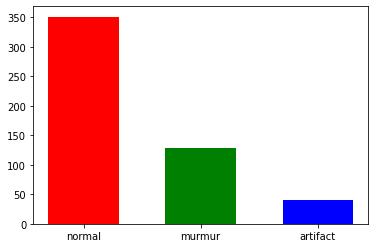

In [14]:
plt.bar(left,class_counts,tick_label=class_label,width=0.6,color=['red', 'green','blue'])

In [15]:
print("Number of training samples:",len(data_ab),"Number of classes:",len(class_label))

Number of training samples: 520 Number of classes: 3


## Feature extraction

In [16]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5

In [17]:
# get audio data with a fix padding may also chop off some file
def load_file_data (folder,file_names, duration=12, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, sr=sr, duration=duration,res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                print ("fixing audio lenght :", file_name)
                y = librosa.util.fix_length(X, input_length)                
            #normalized raw audio 
            y = audio_norm(y)            
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0)             
        except Exception as e:
            print("Error encountered while parsing file: ",file)        
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data

In [18]:
# simple encoding of categories, limited to 3 types
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Map label text to integer
CLASSES = ['artifact','murmur','normal']
# {'artifact': 0, 'murmur': 1, 'normal': 3}
NB_CLASSES=len(CLASSES)

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)
print (" ")
# map integer to label text
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'artifact': 0, 'murmur': 1, 'normal': 2}
 
{0: 'artifact', 1: 'murmur', 2: 'normal'}


## Loading the set-a and set-b datasets

In [19]:
import os, fnmatch

In [44]:
A_folder='C:\\Users\\dell\\audio-data\\set-a\\'
# set-a
A_artifact_files = fnmatch.filter(os.listdir('C:\\Users\\dell\\audio-data\\set-a'), 'artifact*.wav')
A_artifact_sounds = load_file_data(folder=A_folder,file_names=A_artifact_files, duration=MAX_SOUND_CLIP_DURATION)
A_artifact_labels = ['murmur' for items in A_artifact_files]

A_normal_files = fnmatch.filter(os.listdir('C:\\Users\\dell\\audio-data\\set-a'), 'normal*.wav')
A_normal_sounds = load_file_data(folder=A_folder,file_names=A_normal_files, duration=MAX_SOUND_CLIP_DURATION)
A_normal_labels = ['normal' for items in A_normal_sounds]

A_murmur_files = fnmatch.filter(os.listdir('C:\\Users\\dell\\audio-data\\set-a'), 'murmur*.wav')
A_murmur_sounds = load_file_data(folder=A_folder,file_names=A_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
A_murmur_labels = ['murmur' for items in A_murmur_files]

print ("loaded dataset-a")

#%%time 
B_folder='C:\\Users\\dell\\audio-data\\set-b\\'
# set-b
B_normal_files = fnmatch.filter(os.listdir('C:\\Users\\dell\\audio-data\\set-b'), 'normal*.wav')  # include noisy files
B_normal_sounds = load_file_data(folder=B_folder,file_names=B_normal_files, duration=MAX_SOUND_CLIP_DURATION)
B_normal_labels = ['normal' for items in B_normal_sounds]

B_murmur_files = fnmatch.filter(os.listdir('C:\\Users\\dell\\audio-data\\set-b'), 'murmur*.wav')  # include noisy files
B_murmur_sounds = load_file_data(folder=B_folder,file_names=B_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
B_murmur_labels = ['murmur' for items in B_murmur_files]

print ("loaded dataset-b")

load file  C:\Users\dell\audio-data\set-a\artifact__201012172012.wav
fixing audio lenght : artifact__201012172012.wav
load file  C:\Users\dell\audio-data\set-a\artifact__201105040918.wav


C:\Users\dell\AppData\Local\Temp\ipykernel_10400\3315501693.py:17: FutureWarning: Pass size=192000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y = librosa.util.fix_length(X, input_length)


fixing audio lenght : artifact__201105040918.wav
load file  C:\Users\dell\audio-data\set-a\artifact__201105041959.wav
fixing audio lenght : artifact__201105041959.wav
load file  C:\Users\dell\audio-data\set-a\artifact__201105051017.wav
fixing audio lenght : artifact__201105051017.wav
load file  C:\Users\dell\audio-data\set-a\artifact__201105060108.wav
fixing audio lenght : artifact__201105060108.wav
load file  C:\Users\dell\audio-data\set-a\artifact__201105061143.wav
fixing audio lenght : artifact__201105061143.wav
load file  C:\Users\dell\audio-data\set-a\artifact__201105190800.wav
fixing audio lenght : artifact__201105190800.wav
load file  C:\Users\dell\audio-data\set-a\artifact__201105280851.wav
fixing audio lenght : artifact__201105280851.wav
load file  C:\Users\dell\audio-data\set-a\artifact__201106010559.wav
fixing audio lenght : artifact__201106010559.wav
load file  C:\Users\dell\audio-data\set-a\artifact__201106010602.wav
fixing audio lenght : artifact__201106010602.wav
load fi

In [45]:
x_data = np.concatenate(( A_normal_sounds,A_murmur_sounds,A_artifact_sounds,
                         B_normal_sounds,B_murmur_sounds))

y_data = np.concatenate((A_normal_labels,A_murmur_labels,A_artifact_labels,
                         B_normal_labels,B_murmur_labels))

In [46]:
x_data=np.squeeze(x_data)

## Spliting the dataset into training and testing

In [47]:
seed = 1000
# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=seed)

## Logistic regression algorithm

In [48]:
from sklearn.linear_model import LogisticRegression
logi_reg=LogisticRegression()
logi_reg.fit(x_train,y_train)
ypred_logi=logi_reg.predict(x_test)

c:\users\dell\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:
from sklearn.metrics import accuracy_score,confusion_matrix
acc_logi=accuracy_score(y_test,ypred_logi)
print("logistic regression accuracy=",acc_logi*100)

logistic regression accuracy= 78.84615384615384


In [50]:
cm_logi=confusion_matrix(y_test,ypred_logi)
print(cm_logi)

[[17 17]
 [ 5 65]]


<AxesSubplot:>

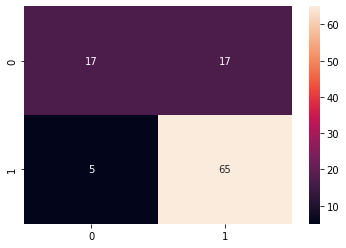

In [51]:
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
sb.heatmap(cm_logi,annot=True)

c:\users\dell\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

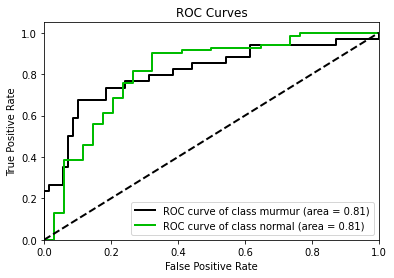

<Figure size 432x288 with 0 Axes>

In [52]:
import scikitplot as skplt
prob_logi=logi_reg.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_test,prob_logi,curves=("each_class"))
plt.figure()

## Random forest algorithm

In [53]:
from sklearn.ensemble import RandomForestClassifier
mod_RF=RandomForestClassifier()
mod_RF.fit(x_train,y_train)
pred_RF=mod_RF.predict(x_test)

In [54]:
acc_RF=accuracy_score(y_test,pred_RF)
print("random forest accuracy=",acc_RF*100)

random forest accuracy= 84.61538461538461


<AxesSubplot:>

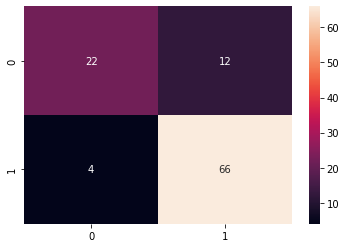

In [55]:
cm_RF=confusion_matrix(y_test,pred_RF)
sb.heatmap(cm_RF,annot=True)

c:\users\dell\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

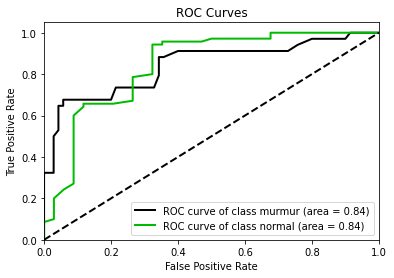

<Figure size 432x288 with 0 Axes>

In [56]:
prob_RF=mod_RF.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_test,prob_RF,curves=("each_class"))
plt.figure()

## Ada-boost algorithm

c:\users\dell\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

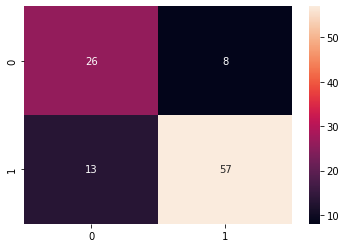

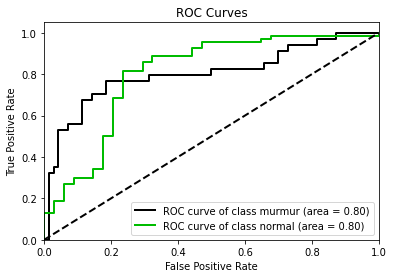

<Figure size 432x288 with 0 Axes>

In [57]:
from sklearn.ensemble import AdaBoostClassifier
mod_ada=AdaBoostClassifier()
mod_ada.fit(x_train,y_train)
pred_ada=mod_ada.predict(x_test)

cm_ada=confusion_matrix(y_test,pred_ada)
sb.heatmap(cm_ada,annot=True)
prob_ada=mod_ada.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_test,prob_ada,curves=("each_class"))
plt.figure()

In [58]:
acc_ada=accuracy_score(y_test,pred_ada)
print("Ada-boost algorithm accuracy=",acc_ada*100)

Ada-boost algorithm accuracy= 79.8076923076923


## Support vector machine algorithm

c:\users\dell\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

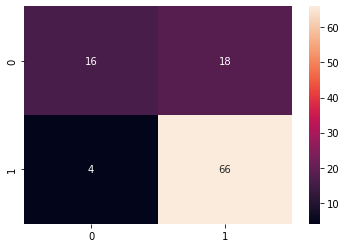

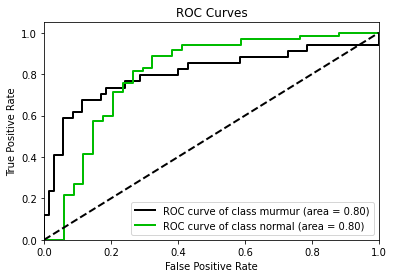

<Figure size 432x288 with 0 Axes>

In [59]:
from sklearn.svm import SVC
mod_svc=SVC(kernel='linear',probability = True)
mod_svc.fit(x_train,y_train)
pred_svc=mod_svc.predict(x_test)
cm_svc=confusion_matrix(y_test,pred_svc)
sb.heatmap(cm_svc,annot=True)
prob_svc=mod_svc.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_test,prob_svc,curves=("each_class"))
plt.figure()

In [65]:
acc_svc=accuracy_score(y_test,pred_svc)
print("Support vector machine accuracy=",acc_svc*100)

Support vector machine accuracy= 78.84615384615384


In [61]:
ACC=pd.DataFrame({'Algorithm':['Logistic Regression', 'Random Forest','Adaboost','SVM'],'Accuracy':[acc_logi*100,acc_RF*100,acc_ada*100,acc_svc*100]},columns=['Algorithm','Accuracy'])


## Accuracy of each algorithm

In [62]:
ACC.head()

,Algorithm,Accuracy
0,Logistic Regression,78.846154
1,Random Forest,84.615385
2,Adaboost,79.807692
3,SVM,78.846154


## feature extraction for the prediction

In [63]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

    return mfccs_scaled_features

## Prediction of new data

In [64]:
file_name="C:\\Users\\dell\\Desktop\\normal.wav"

mfccs = features_extractor(file_name)
#print(len(mfccs))
prediction=mod_svc.predict(mfccs.reshape(1,-1))
print(prediction)

['normal']
